# Test Factor Models VaR and ES
This notebook demonstrates how to use:
- A single-factor model Value-at-Risk (VaR) and Expected Shortfall (ES)
- A Fama-French 3-factor model for VaR and ES

It uses historical return data and factor models to estimate portfolio risk.

In [24]:
import data_download as dd
import factor_models as fm
import pandas as pd
import numpy as np
import plots
import backtesting as bt

##  Download data and form a portfolio

In [25]:
# Define tickers and shares
tickers = [
    "AAPL", "MSFT", "NVDA", "GOOGL", "JPM",
    "UNH", "KO", "PEP", "BMW.DE", "NESN.SW",
    "NOVN.SW", "ASML.AS"
]

# Assign number of shares per asset
shares = pd.Series(10, index=tickers)

# Download adjusted prices
prices = dd.get_raw_prices(tickers, start="2021-01-01", end="2022-01-01")

# Compute daily value of each position
position_values = prices * shares

# Compute total portfolio value over time
portfolio_value_series = position_values.sum(axis=1)

# Compute asset weights (based on latest available prices)
latest_prices = prices.iloc[-1]
portfolio_value = (shares * latest_prices).sum()
weights = (shares * latest_prices) / portfolio_value

# Compute daily asset returns and portfolio returns
returns = prices.pct_change().dropna()
portfolio_returns = returns @ weights

# Combine historical values into one DataFrame
portfolio_df = position_values.copy()
portfolio_df["PORTFOLIO"] = portfolio_value_series

# Display results
portfolio_df.head()


,AAPL,ASML.AS,BMW.DE,GOOGL,JPM,KO,MSFT,NESN.SW,NOVN.SW,NVDA,PEP,UNH,PORTFOLIO
Date,,,,,,,,,,,,,
2021-01-04,1262.397156,3899.460449,525.135841,858.958435,1116.209564,463.888397,2096.171722,906.904449,645.920181,130.790977,1274.671936,3286.761475,16467.270584
2021-01-05,1278.004837,3905.699768,517.828026,865.885239,1122.283096,458.788757,2098.193970,899.959030,642.736740,133.695860,1278.470612,3242.561340,16444.107275
2021-01-06,1234.985352,3866.825562,518.778000,857.341003,1174.980927,444.193420,2043.789062,887.978134,642.503738,125.814104,1262.832184,3378.639526,16438.661013
2021-01-07,1277.126770,3876.903992,518.997269,882.948685,1213.566208,439.269676,2101.949005,886.588974,638.932228,133.089933,1258.767853,3432.807922,16660.948515
2021-01-08,1288.149872,3993.527527,515.124207,894.637833,1214.905930,449.117088,2114.756317,879.990768,644.444962,132.419205,1273.876343,3417.384644,16818.334694


In [26]:
print(weights)

AAPL       0.071517
ASML.AS    0.279871
BMW.DE     0.027791
GOOGL      0.059156
JPM        0.059068
KO         0.022036
MSFT       0.134001
NESN.SW    0.046579
NOVN.SW    0.026621
NVDA       0.012047
PEP        0.064818
UNH        0.196495
dtype: float64


In [27]:
portfolio_value

24370.104637145996

## Single-Factor VaR and ES

The Single-Factor model assumes that all asset returns are driven by a single common factor — typically the market index.  
This is also referred to as the **Sharpe Single-Index Model**, and is a special case of the delta-normal method.

Each asset’s return is modeled as:

$$
R_i = \alpha_i + \beta_i R_m + \varepsilon_i
$$

where:
- $R_m$ is the market return
- $\beta_i$ is the sensitivity of asset $i$ to the market
- $\varepsilon_i$ is the idiosyncratic (asset-specific) risk

The total variance of asset $i$ is:

$$
\sigma_i^2 = \beta_i^2 \sigma_m^2 + \sigma_{\varepsilon_i}^2
$$

The portfolio’s covariance matrix is approximated as:

$$
\Sigma = \beta \beta^T \cdot \sigma_m^2 + D
$$

where:
- $\beta$: vector of asset betas
- $\sigma_m^2$: variance of the market return
- $D$: diagonal matrix of idiosyncratic variances

Finally, the portfolio VaR at confidence level $\alpha$ is given by:

$$
\text{VaR}_{\alpha} = z_\alpha \cdot \sigma_p \cdot \text{PortfolioValue}
$$

and the Expected Shortfall (ES) is:

$$
\text{ES}_{\alpha} = \frac{\phi(z_\alpha)}{1 - \alpha} \cdot \sigma_p \cdot \text{PortfolioValue}
$$

where $z_\alpha$ is the quantile of the standard normal distribution and $\phi$ is the standard normal PDF.


In [28]:
# download SP prices
sp = dd.get_raw_prices(["^GSPC"], start="2021-01-01", end="2022-01-01")

# compute benchmark returns
benchmark = sp["^GSPC"].pct_change().dropna()

# align benchmark with asset returns
benchmark = benchmark.reindex(returns.index).ffill()

In [29]:
results_df, portfolio_volatility = fm.single_factor_var(
    returns=returns,
    benchmark=benchmark,
    weights=weights,
    portfolio_value=portfolio_value,
    confidence_level=0.99
)


In [30]:
results_df.head()   

,Returns,Benchmark,VaR,VaR Violation,VaR_monetary
Date,,,,,
2021-01-05,-0.001039,0.007083,0.022386,False,545.556683
2021-01-06,-0.001014,0.005710,0.022386,False,545.556683
2021-01-07,0.013875,0.014847,0.022386,False,545.556683
2021-01-08,0.010705,0.005492,0.022386,False,545.556683
2021-01-11,-0.007217,-0.006555,0.022386,False,545.556683



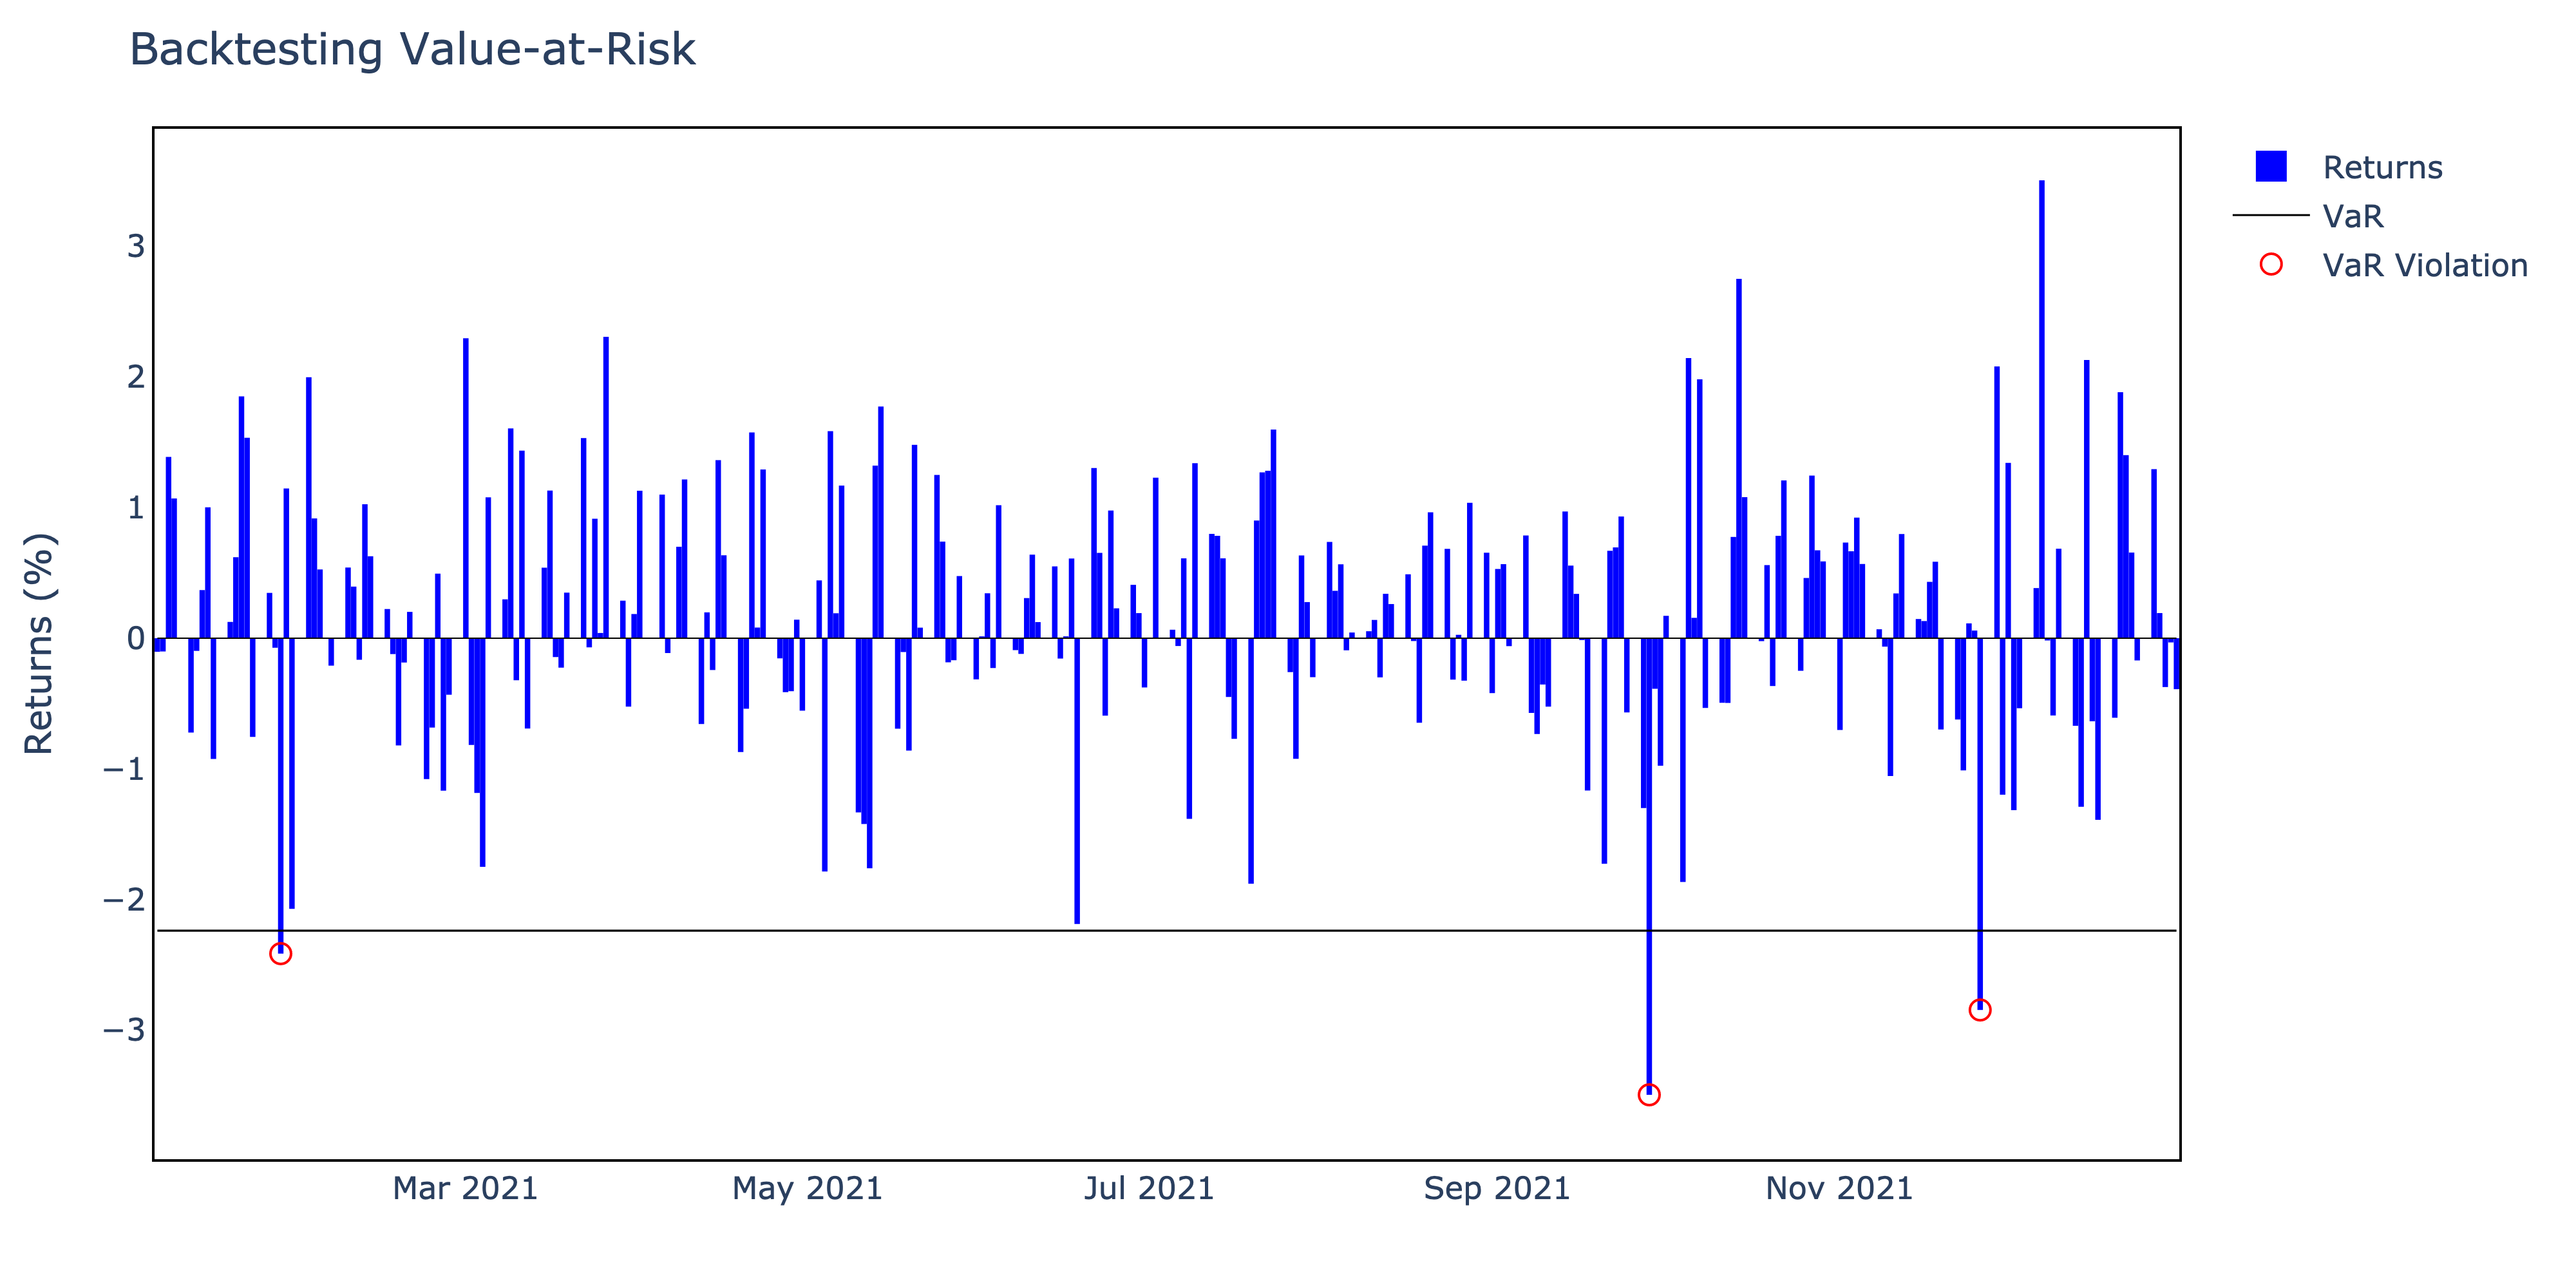

In [31]:
# Plot interactive VaR
fig_var = plots.plot_backtest(results_df, interactive=False)

In [32]:
results_df = fm.factor_models_es(
    result_data= results_df,
    portfolio_volatility=portfolio_volatility,
    confidence_level = 0.99
)

In [33]:
results_df.head()


,Returns,Benchmark,VaR,VaR Violation,VaR_monetary,ES,ES_monetary
Date,,,,,,,
2021-01-05,-0.001039,0.007083,0.022386,False,545.556683,0.025647,625.024936
2021-01-06,-0.001014,0.005710,0.022386,False,545.556683,0.025647,625.024936
2021-01-07,0.013875,0.014847,0.022386,False,545.556683,0.025647,625.024936
2021-01-08,0.010705,0.005492,0.022386,False,545.556683,0.025647,625.024936
2021-01-11,-0.007217,-0.006555,0.022386,False,545.556683,0.025647,625.024936



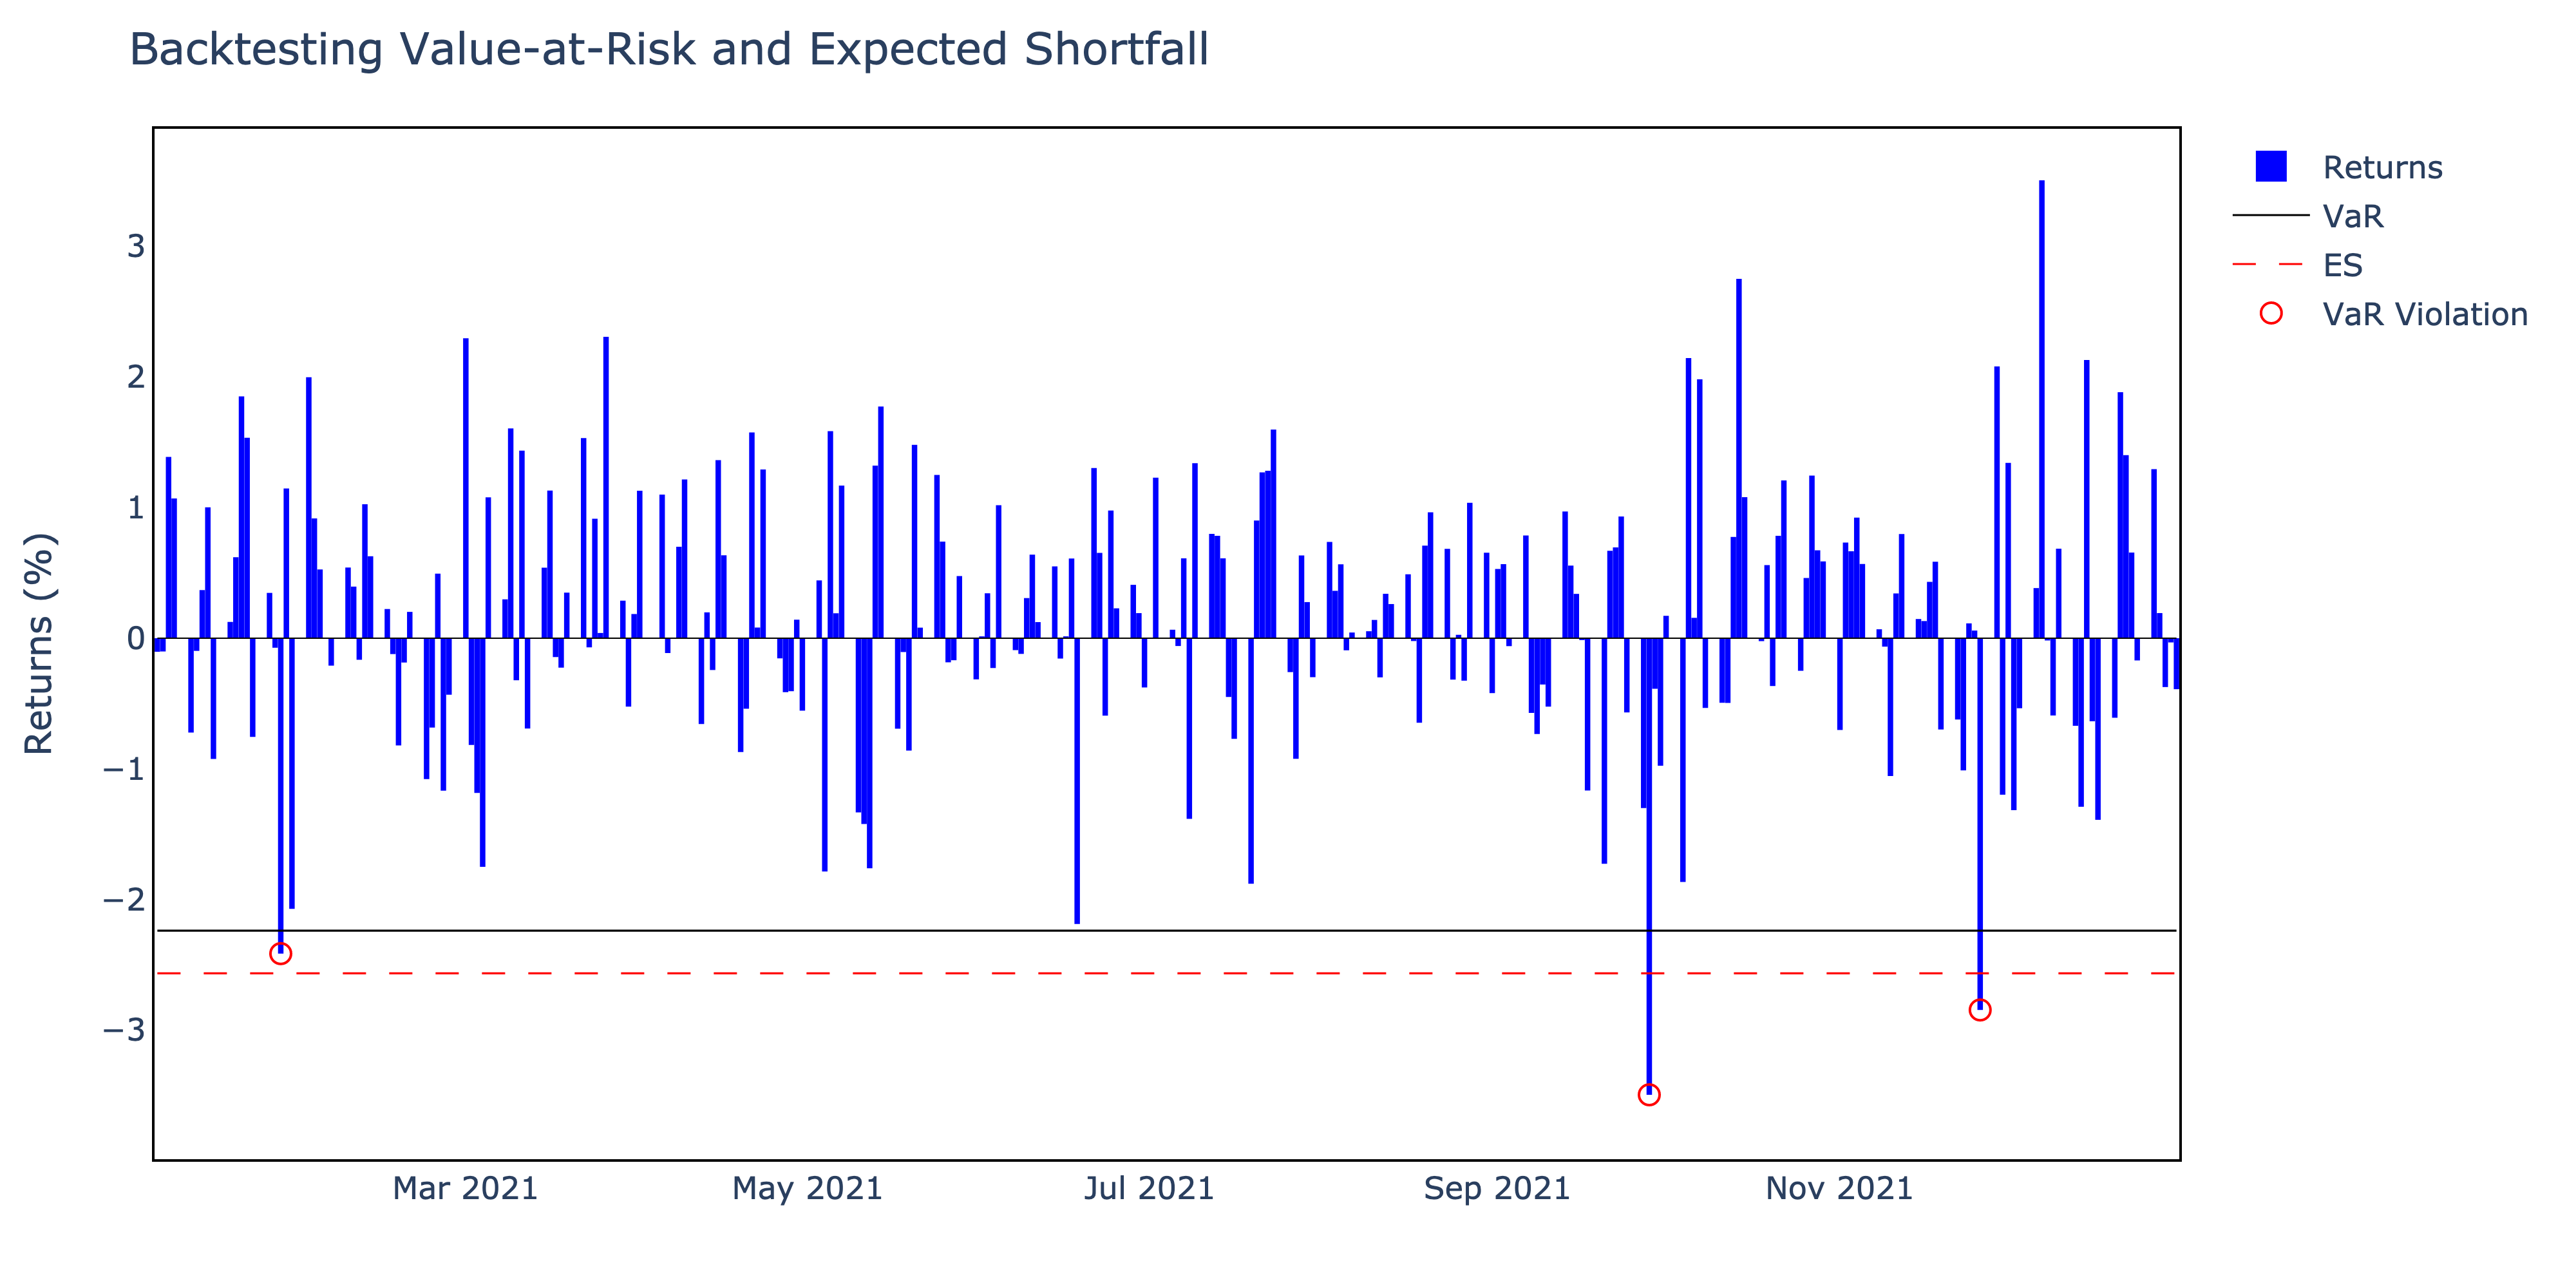

In [34]:
# Plot interactive VaR
fig_var = plots.plot_backtest(results_df, interactive=False)

In [35]:
violations, violation_rate = bt.count_violations(results_df)

violations, violation_rate

(3, 0.011627906976744186)

## Fama-French 3-Factor VaR and ES

The Fama–French 3-factor model extends the CAPM by modeling asset returns using three sources of systematic risk:

- **Mkt_RF**: excess return of the market over the risk-free rate  
- **SMB** ("Small Minus Big"): return of small-cap stocks minus large-cap  
- **HML** ("High Minus Low"): return of high book-to-market stocks minus low  

Each asset’s excess return is regressed on these three factors to estimate its **exposures (betas)**. The model assumes:

$$
R_i - R_f = \alpha_i + \beta_{i1} \cdot \text{Mkt}_{RF} + \beta_{i2} \cdot \text{SMB} + \beta_{i3} \cdot \text{HML} + \varepsilon_i
$$

The estimated covariance matrix of asset returns is reconstructed as:

$$
\Sigma = B \cdot \Sigma_f \cdot B^T + D
$$

Where:
- $B$: matrix of asset betas  
- $\Sigma_f$: covariance matrix of factor returns  
- $D$: diagonal matrix of idiosyncratic variances  

The next code block performs the following steps:

1. Downloads the FF3 daily factor data from Ken French's database.
2. Computes **excess returns** for each asset over the risk-free rate.
3. Regresses each asset’s excess return on the three factors to obtain:
   - **Beta coefficients** (exposures to Mkt_RF, SMB, HML)
   - **Idiosyncratic variance** (residual risk)
4. Builds the **full covariance matrix** of asset returns using the factor structure.
5. Computes **portfolio volatility** using the covariance matrix and current weights.
6. Calculates:
   - **Value-at-Risk (VaR)** at the given confidence level
   - **Conditional VaR (CVaR)**, i.e. expected loss beyond the VaR threshold

The printed outputs show all key components estimated during this process.

In [36]:
# # Download FF3 daily factors and restrict to portfolio date range
# ff_factors = fm.load_ff3_factors(start=returns.index[0], end=returns.index[-1])

# # Check first few rows
# ff_factors.head()

In [37]:
new_df, portfolio_volatility_new = fm.fama_french_var(
    returns=returns, 
    weights=weights,
    portfolio_value=portfolio_value,
    confidence_level=0.99
)

new_df.head()

,Returns,Factor_Mkt_RF,Factor_SMB,Factor_HML,VaR,VaR Violation,VaR_monetary
Date,,,,,,,
2021-01-05,-0.001039,0.0086,0.0124,0.0048,0.022112,False,538.867585
2021-01-06,-0.001014,0.0079,0.0217,0.0391,0.022112,False,538.867585
2021-01-07,0.013875,0.0176,0.0030,-0.0079,0.022112,False,538.867585
2021-01-08,0.010705,0.0051,-0.0079,-0.0132,0.022112,False,538.867585
2021-01-11,-0.007217,-0.0052,0.0028,0.0124,0.022112,False,538.867585


In [38]:
results_df_new = fm.factor_models_es(
    result_data= new_df,
    portfolio_volatility=portfolio_volatility_new,
    confidence_level = 0.99
)

results_df_new.head()   

,Returns,Factor_Mkt_RF,Factor_SMB,Factor_HML,VaR,VaR Violation,VaR_monetary,ES,ES_monetary
Date,,,,,,,,,
2021-01-05,-0.001039,0.0086,0.0124,0.0048,0.022112,False,538.867585,0.025333,617.361474
2021-01-06,-0.001014,0.0079,0.0217,0.0391,0.022112,False,538.867585,0.025333,617.361474
2021-01-07,0.013875,0.0176,0.0030,-0.0079,0.022112,False,538.867585,0.025333,617.361474
2021-01-08,0.010705,0.0051,-0.0079,-0.0132,0.022112,False,538.867585,0.025333,617.361474
2021-01-11,-0.007217,-0.0052,0.0028,0.0124,0.022112,False,538.867585,0.025333,617.361474



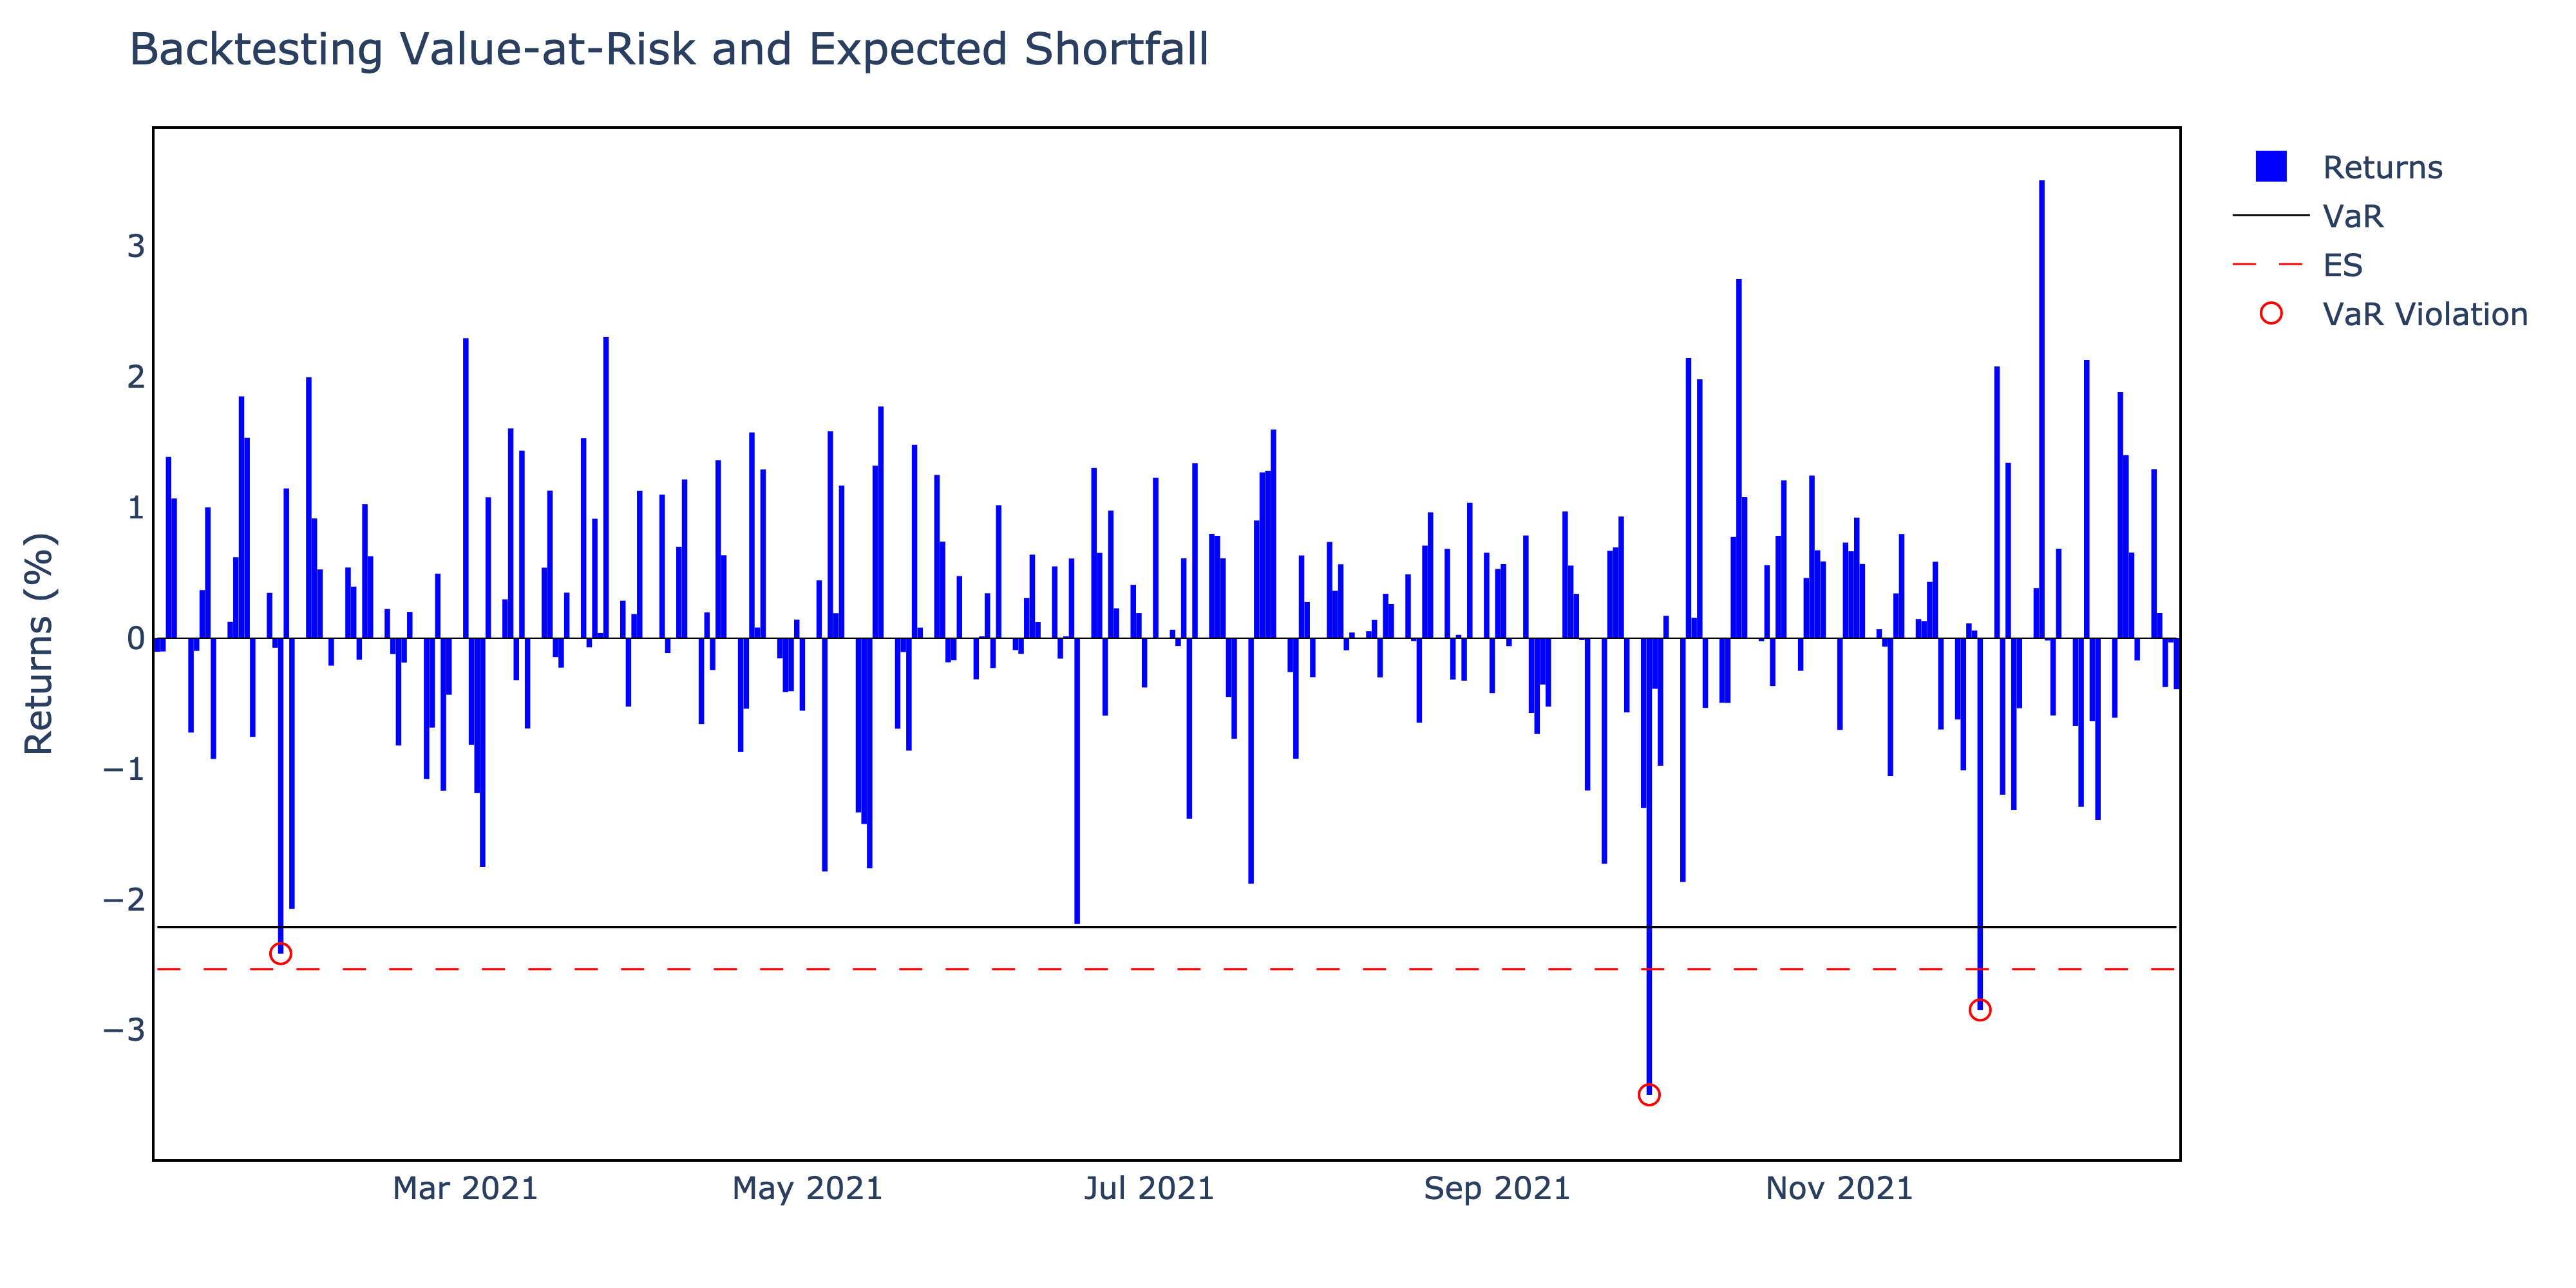

In [39]:
# Plot interactive VaR
fig_var = plots.plot_backtest(results_df_new, interactive=False)

In [40]:
violations_new, violation_rate_new = bt.count_violations(results_df_new)

violations_new, violation_rate_new

(3, 0.011627906976744186)